In [1]:
# Cài đặt các thư viện cần thiết từ file requirements của YOLOv5
# Clone repo trước rồi cài đặt
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -qr requirements.txt

# Quay lại thư mục làm việc gốc
%cd /kaggle/working/

# Imports các thư viện Python
import os
import glob
import shutil
import yaml
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from IPython.display import Image, display

Cloning into 'yolov5'...
remote: Enumerating objects: 17496, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 17496 (delta 2), reused 0 (delta 0), pack-reused 17490 (from 3)
Receiving objects: 100% (17496/17496), 16.59 MiB | 24.73 MiB/s, done.
Resolving deltas: 100% (11993/11993), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.4 MB/s eta 

In [2]:
# Ô 2: Đọc thông tin từ file YAML đã upload 

import yaml
import shutil # Đảm bảo đã import shutil

# Đường dẫn đến file YAML 
YAML_UPLOADED_PATH = '/kaggle/input/ts-yaml/dataset.yaml' 

# Đọc file YAML gốc để lấy thông tin lớp
with open(YAML_UPLOADED_PATH, 'r') as f:
    yaml_data = yaml.safe_load(f)

class_names = yaml_data['names']
num_classes = yaml_data['nc']
class_to_id = {name: i for i, name in enumerate(class_names)}

YOLO_YAML_PATH = '/kaggle/working/yolov5/data/traffic_sign_dataset.yaml'

# Sao chép file từ /input (chỉ đọc) sang /working (có thể ghi/sửa)
shutil.copy(YAML_UPLOADED_PATH, YOLO_YAML_PATH)

# Mở file ĐÃ SAO CHÉP ở /working để chỉnh sửa đường dẫn
with open(YOLO_YAML_PATH, 'r') as f:
    temp_yaml_data = yaml.safe_load(f)

# Cập nhật lại đường dẫn để trỏ đúng đến nơi chứa dữ liệu đã xử lý
temp_yaml_data['path'] = '/kaggle/working/dataset'
temp_yaml_data['train'] = 'images/train'
temp_yaml_data['val'] = 'images/val'

# Ghi lại những thay đổi vào file YAML trong /working
with open(YOLO_YAML_PATH, 'w') as f:
    yaml.dump(temp_yaml_data, f, sort_keys=False)


print(f"Đã đọc và sao chép file YAML. Sẵn sàng cho các bước tiếp theo.")
print(f"Số lượng lớp: {num_classes}")
print(f"\nNội dung file YAML sẽ được dùng để training (tại {YOLO_YAML_PATH}):")
!cat {YOLO_YAML_PATH}

Đã đọc và sao chép file YAML. Sẵn sàng cho các bước tiếp theo.
Số lượng lớp: 76

Nội dung file YAML sẽ được dùng để training (tại /kaggle/working/yolov5/data/traffic_sign_dataset.yaml):
path: /kaggle/working/dataset
train: images/train
val: images/val
nc: 76
names:
- regulatory--keep-right
- regulatory--height-limit
- warning--railroad-crossing-with-barriers
- warning--falling-rocks-or-debris-right
- regulatory--yield
- warning--curve-right
- regulatory--pedestrians-only
- warning--pedestrians-crossing
- regulatory--no-entry
- warning--slippery-road-surface
- warning--curve-left
- information--parking
- information--tram-bus-stop
- warning--crossroads
- regulatory--stop
- regulatory--maximum-speed-limit
- regulatory--turn-right
- warning--roundabout
- warning--road-bump
- warning--uneven-road
- warning--railroad-crossing-without-barriers
- regulatory--bicycles-only
- regulatory--yield-to-oncoming-traffic
- regulatory--shared-path-pedestrians-and-bicycles
- regulatory--no-bicycles
- reg

In [3]:
# Ô 3: Đọc và xử lý file XML 

DATASET_PATH = '/kaggle/input/traffic-sign-detection' 
IMAGE_DIR = os.path.join(DATASET_PATH, 'images')
XML_DIR = os.path.join(DATASET_PATH, 'xmls')

import pandas as pd
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm
import glob

# Lấy danh sách tất cả các file xml
xml_filepaths = glob.glob(os.path.join(XML_DIR, '*.xml'))

# Hàm để phân tích một file XML
def parse_xml(xml_file):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        image_name = root.find('filename').text
        image_path = os.path.join(IMAGE_DIR, image_name)
        
        image_annotations = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bndbox = obj.find('bndbox')
            
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))
            
            image_annotations.append({
                'image_path': image_path, 'label': label,
                'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax
            })
        return image_annotations
    except Exception as e:
        print(f"Lỗi khi đọc file {xml_file}: {e}")
        return []

# Tạo danh sách dữ liệu từ tất cả các file XML
dataset = []
for xml_file in tqdm(xml_filepaths, desc="Đang đọc file XML"):
    dataset.extend(parse_xml(xml_file))

# Chuyển thành DataFrame của Pandas
df = pd.DataFrame(dataset)
if not df.empty:
    print(f"\nĐã đọc xong. Tổng số annotations: {len(df)}")
    display(df.head())
else:
    print("\nKhông đọc được dữ liệu nào. Vui lòng kiểm tra lại file XML.")

Đang đọc file XML:   0%|          | 0/19346 [00:00<?, ?it/s]


Đã đọc xong. Tổng số annotations: 30558


,image_path,label,xmin,ymin,xmax,ymax
0,/kaggle/input/traffic-sign-detection/images/Mo...,regulatory--turn-right,2592,1555,2639,1598
1,/kaggle/input/traffic-sign-detection/images/Mo...,regulatory--no-left-turn,910,1491,980,1562
2,/kaggle/input/traffic-sign-detection/images/Qv...,warning--road-narrows-right,3491,970,3659,1133
3,/kaggle/input/traffic-sign-detection/images/00...,warning--other-danger,296,895,376,952
4,/kaggle/input/traffic-sign-detection/images/00...,warning--children,505,439,591,523


In [4]:
# Lấy danh sách các ảnh duy nhất
image_paths = df['image_path'].unique()

# Chia danh sách ảnh thành tập train và validation (tỉ lệ 80/20)
train_images, val_images = train_test_split(image_paths, test_size=0.2, random_state=42)

# Tạo các thư mục cần thiết trong thư mục làm việc của Kaggle
for folder in ['train', 'val']:
    os.makedirs(f'/kaggle/working/dataset/images/{folder}', exist_ok=True)
    os.makedirs(f'/kaggle/working/dataset/labels/{folder}', exist_ok=True)

# Hàm xử lý để chuyển đổi và lưu dữ liệu
def process_and_save_data(image_list, split):
    for image_path in tqdm(image_list, desc=f'Đang xử lý tập {split}'):
        img = cv2.imread(image_path)
        h, w, _ = img.shape
        
        # Sao chép ảnh vào thư mục working
        new_image_path = os.path.join(f'/kaggle/working/dataset/images/{split}/', os.path.basename(image_path))
        shutil.copy(image_path, new_image_path)
        
        # Tạo file label .txt
        label_filename = os.path.splitext(os.path.basename(image_path))[0] + '.txt'
        label_path = os.path.join(f'/kaggle/working/dataset/labels/{split}/', label_filename)
        
        annotations = df[df['image_path'] == image_path]
        
        with open(label_path, 'w') as f:
            for _, row in annotations.iterrows():
                class_id = class_to_id[row['label']]
                xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
                
                # Chuẩn hóa tọa độ theo định dạng YOLO
                x_center = (xmin + xmax) / 2 / w
                y_center = (ymin + ymax) / 2 / h
                width = (xmax - xmin) / w
                height = (ymax - ymin) / h
                
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Chạy xử lý cho cả 2 tập
process_and_save_data(train_images, 'train')
process_and_save_data(val_images, 'val')

print("\nĐã hoàn tất việc chuẩn bị dữ liệu theo định dạng YOLOv5.")

Đang xử lý tập train:   0%|          | 0/15238 [00:00<?, ?it/s]

Đang xử lý tập val:   0%|          | 0/3810 [00:00<?, ?it/s]


Đã hoàn tất việc chuẩn bị dữ liệu theo định dạng YOLOv5.


In [5]:
# Di chuyển vào thư mục yolov5 để chạy script
%cd /kaggle/working/yolov5

# Bắt đầu huấn luyện
!python train.py \
    --img 640 \
    --batch 16 \
    --epochs 30 \
    --data data/traffic_sign_dataset.yaml \
    --weights yolov5s.pt \
    --name traffic_sign_run \
    --cache

/kaggle/working/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-06-22 08:14:44.469863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750580084.729302      72 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750580084.805762      72 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register facto

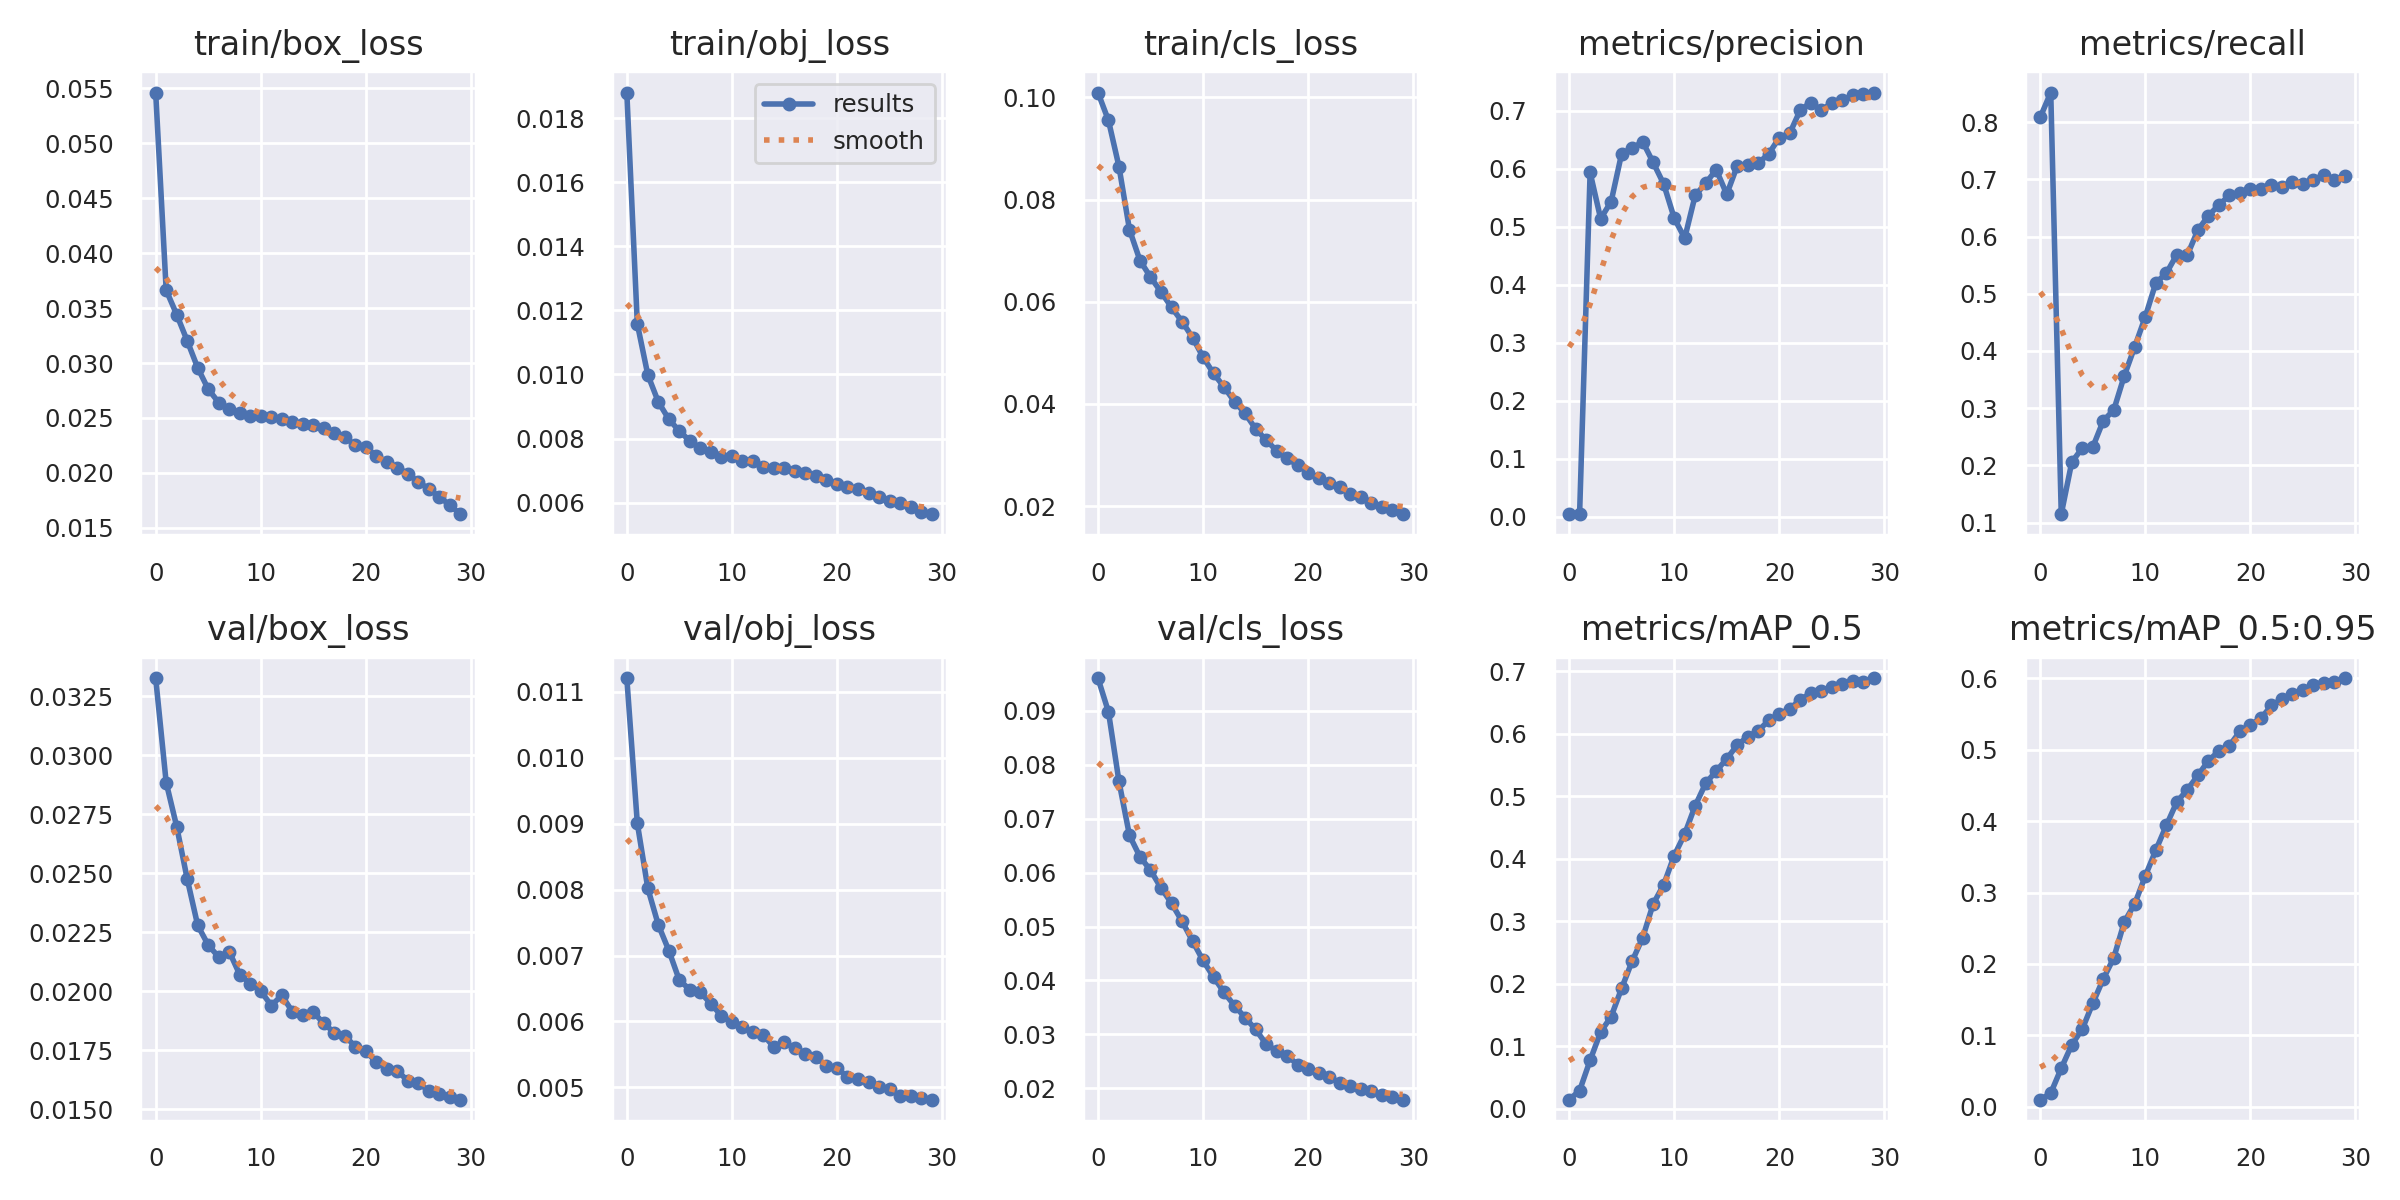

usage: detect.py [-h] [--weights WEIGHTS [WEIGHTS ...]] [--source SOURCE] [--data DATA]
                 [--imgsz IMGSZ [IMGSZ ...]] [--conf-thres CONF_THRES] [--iou-thres IOU_THRES]
                 [--max-det MAX_DET] [--device DEVICE] [--view-img] [--save-txt]
                 [--save-format SAVE_FORMAT] [--save-csv] [--save-conf] [--save-crop] [--nosave]
                 [--classes CLASSES [CLASSES ...]] [--agnostic-nms] [--augment] [--visualize]
                 [--update] [--project PROJECT] [--name NAME] [--exist-ok]
                 [--line-thickness LINE_THICKNESS] [--hide-labels] [--hide-conf] [--half] [--dnn]
                 [--vid-stride VID_STRIDE]
detect.py: error: unrecognized arguments: /kaggle/working/dataset/images/val/GXI0zjvuSqXPvkiF3s9nyA.jpg /kaggle/working/dataset/images/val/6KLL5k8Ftz49sMWZDUG05w.jpg
/kaggle/working


In [6]:
# Hiển thị biểu đồ kết quả training
results_img_path = 'runs/train/traffic_sign_run/results.png'
display(Image(filename=results_img_path, width=800))

# Đường dẫn đến trọng số tốt nhất
best_weights_path = 'runs/train/traffic_sign_run/weights/best.pt'

# Lấy một vài ảnh ngẫu nhiên từ tập validation để dự đoán
# Lưu ý: đường dẫn đến ảnh phải là đường dẫn đầy đủ
val_image_files = glob.glob('/kaggle/working/dataset/images/val/*.jpg')
sample_images_to_predict = np.random.choice(val_image_files, 3)
sample_images_str = " ".join(sample_images_to_predict)

# Chạy detect.py để dự đoán trên các ảnh mẫu
!python detect.py \
    --weights {best_weights_path} \
    --source {sample_images_str} \
    --conf 0.4 \
    --name traffic_sign_detection

# Hiển thị các ảnh đã được dự đoán
# Kết quả sẽ nằm trong runs/detect/traffic_sign_detection
detection_results = glob.glob('runs/detect/traffic_sign_detection/*.jpg')
for img_path in detection_results:
    display(Image(filename=img_path, width=600))
    
# Quay lại thư mục làm việc gốc nếu cần
%cd /kaggle/working/